# *Content*

#### The dataset contains transactions made by credit cards in September 2013 by European cardholders.
#### This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

#### It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

#### Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.
Update (03/05/2021)

In [119]:
# Importing Libraries:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

In [5]:
# Importing the dataset:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [9]:
# Checking how the data looks like
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
#Is there any missing value? No.
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [12]:
# Let's check the distribution of the features:
df.describe()

,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


Text(0.5, 1.0, 'Transactions')

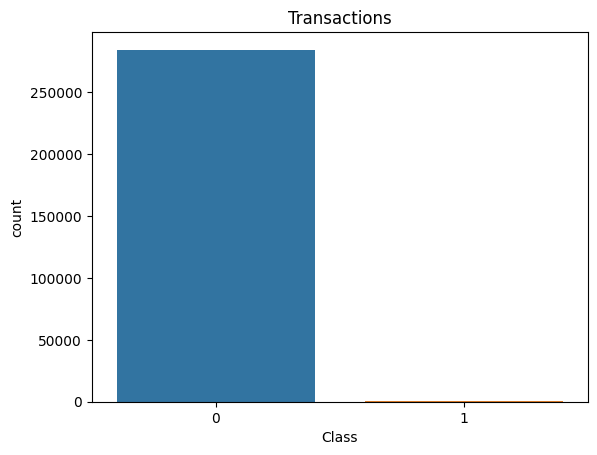

In [7]:
sns.countplot(data=df, x='Class').set_title("Regular Transactions (99.83%) vs Fraud Transactions (0.17%)")

### Step 2: Correlation and  
#### My second step in the analysis is to review the correlation between the variables. However, as the data is highly unbalanced it is hard to see patterns. As you can see below.

In [13]:
corr_plot = df.corr()

<Axes: >

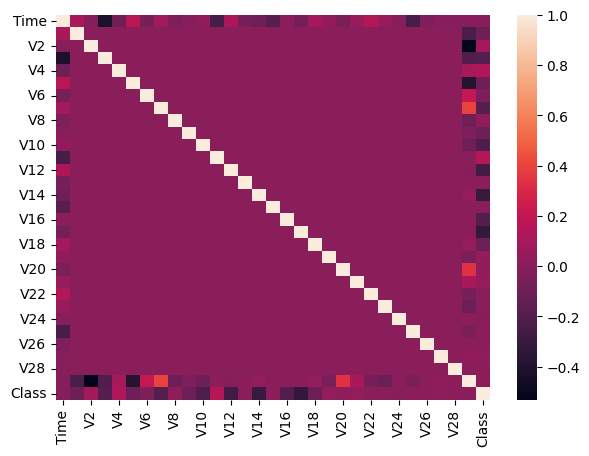

In [19]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
sns.heatmap(data=corr_plot, ax=ax).set_title('')

#### To balance the data there are methods like adding more data (oversampling), reducing one of the parameters (undersampling) or adding synthetic data with methods as SMOTE or ADASYN. In this case I will split the dataset in Class 1 (Fraud) and Class 0 (Regular transaction) and select randomlly a smaller sample. 

In [94]:
# Step 1: Create a DataFrame with 'Class' = 1
df_fraud = df[df['Class'] == 1]

# Step 2: Create a DataFrame with 'Class' = 0
df_reg_trans = df[df['Class'] == 0]

# Step 3: Randomly select the same number of rows from df_class_0 as there are in df_class_1
df_balanced_aux = df_reg_trans.sample(n=len(df_fraud)+250, random_state=42)
df_balanced = pd.concat([df_fraud, df_balanced_aux], axis=0)
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

<Axes: xlabel='Class', ylabel='count'>

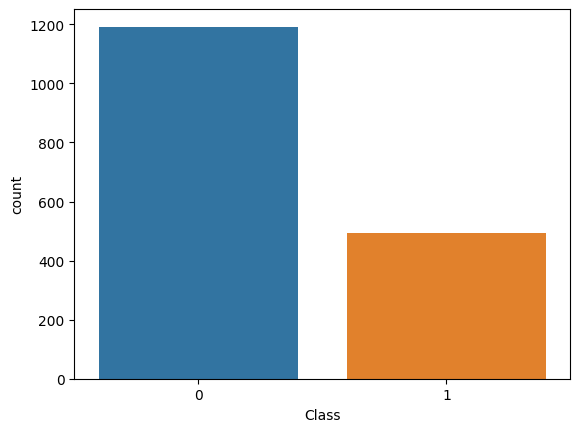

In [95]:
sns.countplot(data=df_balanced, x='Class').set_title('')

<Axes: xlabel='Class', ylabel='Amount'>

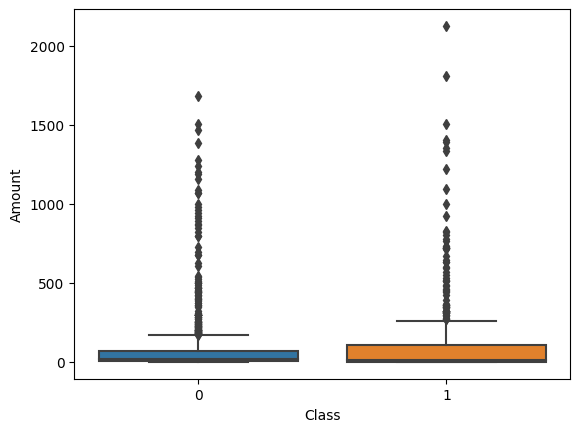

In [96]:
sns.boxplot(data=df_balanced,x='Class', y='Amount').set_title('')

<Axes: xlabel='Class', ylabel='Amount'>

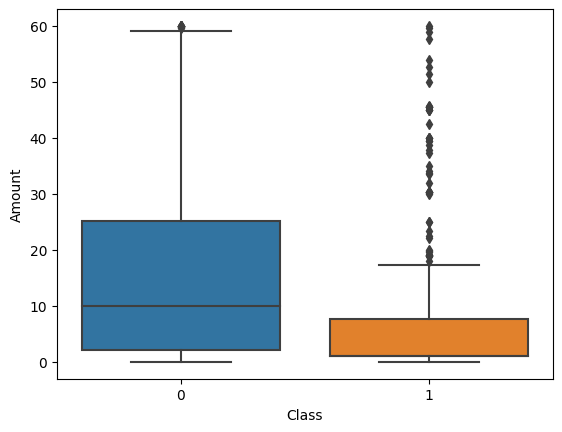

In [102]:
sns.boxplot(data=df_balanced.query("Amount <=100"),x='Class', y='Amount').set_title('')

#### As you can appreciate in the following heatmap, there are more visible patterns.

<Axes: >

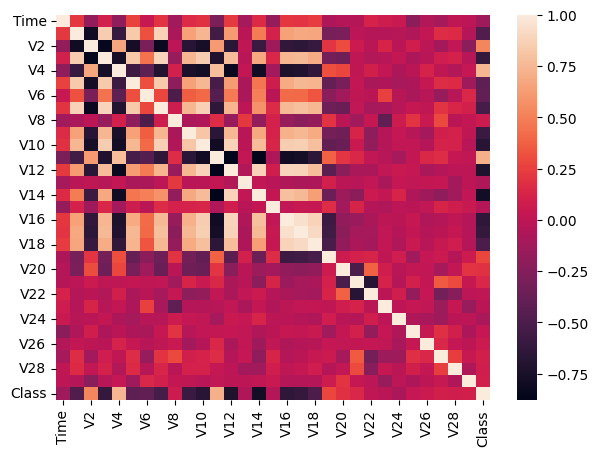

In [78]:
b_corr_plot = df_balanced.corr().set_title('')
fig, ax = plt.subplots(1,1,figsize=(7,5))
sns.heatmap(data=b_corr_plot, ax=ax)

In [79]:
class_corr = b_corr_plot['Class'].sort_values(ascending=True)

[Text(0, 0, 'V14'),
 Text(1, 0, 'V12'),
 Text(2, 0, 'V10'),
 Text(3, 0, 'V16'),
 Text(4, 0, 'V3'),
 Text(5, 0, 'V17'),
 Text(6, 0, 'V9'),
 Text(7, 0, 'V7'),
 Text(8, 0, 'V18'),
 Text(9, 0, 'V1'),
 Text(10, 0, 'V5'),
 Text(11, 0, 'V6'),
 Text(12, 0, 'Time'),
 Text(13, 0, 'V24'),
 Text(14, 0, 'V13'),
 Text(15, 0, 'V15'),
 Text(16, 0, 'V23'),
 Text(17, 0, 'V22'),
 Text(18, 0, 'V25'),
 Text(19, 0, 'V26'),
 Text(20, 0, 'V8'),
 Text(21, 0, 'V28'),
 Text(22, 0, 'Amount'),
 Text(23, 0, 'V27'),
 Text(24, 0, 'V21'),
 Text(25, 0, 'V20'),
 Text(26, 0, 'V19'),
 Text(27, 0, 'V2'),
 Text(28, 0, 'V11'),
 Text(29, 0, 'V4')]

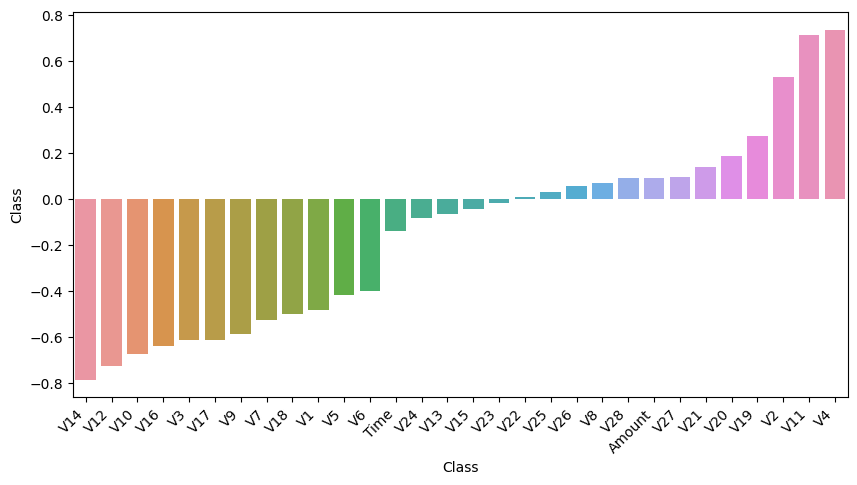

In [80]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.barplot(data=class_corr[:-1], x=class_corr[:-1].index, y=class_corr[:-1])
ax.set_xticklabels(class_corr[:-1].index, rotation=45, ha='right')

## Hyperparameters Tuning and Cross Validation:
#### Let's use the most correlated parameters with the Class in a Supervised ML Model (Random Forest) to predict the Class for unknown transactions. For this, I will split the data in a training and a testing samples and provide a grid with some features to test which combination provides the best one using Stratified KFolding.

## Model: 
#### A Random Forest builds multiple decision trees with different convinations of parameters. Each tree provides an outcome as vote and the most voted result is the prediction.

#### A decision tree is structured like a flowchart where each internal node represents a test or decision based on a feature, each branch corresponds to the outcome of the test, and each leaf node represents a final prediction or output. The model works by recursively splitting the data into subsets based on the feature that provides the most information gain, effectively partitioning the data into increasingly homogenous groups.

## Hyperparameter tuning: 
#### It is the process of optimizing the settings of a machine learning model to improve its performance.

## Cross-Validation: 
#### It is a technique that involves dividing the data into multiple subsets to train and evaluate the model on different combinations of these subsets to ensure its generalizability, and stratified K-fold is a type of cross-validation where the data is split into K subsets (folds) in such a way that each fold maintains the same proportion of classes as the original dataset.

In [110]:
X = df_balanced[['V4','V11','V2','V19','V20']]
y = df_balanced['Class']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [111]:
# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Setup GridSearchCV with StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=skf,
    scoring='roc_auc',
    n_jobs=-1
)

In [113]:
# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

In [115]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

Let's evaluate the model predictions:

## Evaluation Metrics:
### Confusion Matrix: 
#### A table showing the number of correct and incorrect predictions categorized by class, with True Positives (TP), False Positives (FP), False Negatives (FN), and True Negatives (TN).

### Precision: 
#### The ratio of correctly predicted positive instances to the total predicted positives, measuring the accuracy of positive predictions.

### Recall: 
#### The ratio of correctly predicted positive instances to the total actual positives, measuring the model's ability to identify all positive instances.

### F1-Score: 
#### The harmonic mean of precision and recall, providing a balance between the two, especially useful for imbalanced datasets.

### Support: 
#### The number of actual instances of each class in the dataset, indicating the distribution of the classes.

### ROC AUC Score: 
#### The Area Under the Receiver Operating Characteristic Curve, measuring the model's ability to distinguish between classes, with higher values indicating better performance.

Text(0.5, 1.0, 'Confusion Matrix')

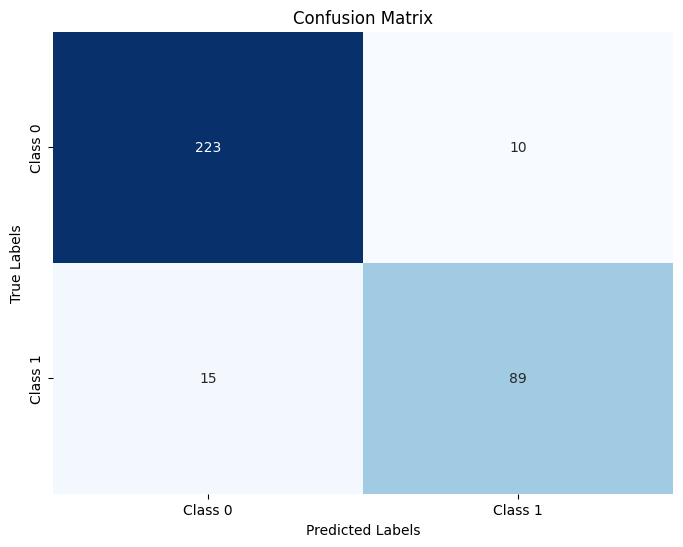

In [116]:
# Evaluate the model
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

In [136]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_prob))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       233
           1       0.90      0.86      0.88       104

    accuracy                           0.93       337
   macro avg       0.92      0.91      0.91       337
weighted avg       0.93      0.93      0.93       337


ROC AUC Score:
0.9729283591944536


## Conclusion:
#### 93% of the time the model predicts correctly. 
#### The model performs strongly, with a slight skew toward better performance in predicting the majority class (class 0) naturally, but still maintains good results for class 1.
#### I could keep tuning the current parameters, adding more of them, playing with the size of the sample, giving a try to other ML algorithms but, overall, I am satisfied with the result.